Import libraries & data

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.preprocessing import PolynomialFeatures

In [2]:
X_train = pd.read_csv('datasets/X_train_inter.csv')
X_test = pd.read_csv('datasets/X_test_inter.csv', )
y_train = pd.read_csv('datasets/y_train_inter.csv')
X_train.shape, y_train.shape, X_test.shape, 

((2051, 404), (2051, 1), (878, 404))

---
# Modeling

In [3]:
from sklearn.metrics import mean_squared_error

### MLR
Fit to basic:

In [4]:
print('\nBasic y:')

ols = LinearRegression()
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_train, y_train, random_state=42)

ols.fit(Xs_train, ys_train)
print('score:', ols.score(Xs_test, ys_test))
print('cvs:', cross_val_score(ols, Xs_test, ys_test, cv=42).mean())

ys_pred = ols.predict(Xs_test)
print('RMSE:', np.sqrt(mean_squared_error(ys_test, ys_pred)))

print('\nAfter log-transforming y:')
y_train_log = y_train.apply(np.log)
Xs_trainl, Xs_testl, ys_trainl, ys_testl = train_test_split(
    X_train, y_train_log, random_state=4)

olsl = LinearRegression()
olsl.fit(Xs_trainl, ys_trainl)
print('score:', olsl.score(Xs_testl, ys_testl))
# cvs on train because test gets weird results...
print('cvs:', cross_val_score(olsl, Xs_trainl, ys_trainl, cv=42).mean())

ys_predl = olsl.predict(Xs_testl)
ys_predl = np.exp(ys_predl)
print('RMSE:', np.sqrt(mean_squared_error(ys_testl, ys_predl)))


Basic y:
score: 0.9108668211768972
cvs: 0.7286444695571217
RMSE: 23394.014667540003

After log-transforming y:
score: 0.796944448630713
cvs: 0.8967441173575628
RMSE: 202847.3867815506


In [5]:
# create submission
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = y_pred
output.to_csv('submissions/submission_f_ols.csv', index=False)
output.head()

,Id,SalePrice
0,2658,122009.467909
1,2718,153036.831519
2,2414,214214.958949
3,1989,112835.752780
4,625,179754.111429


In [6]:
# create log submission
olsl.fit(X_train, y_train_log)
y_pred = olsl.predict(X_test)
y_pred = np.exp(y_pred)
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = y_pred
output.to_csv('submissions/submission_f_ols_log.csv', index=False)
output.head()

,Id,SalePrice
0,2658,85696.410161
1,2718,151469.395876
2,2414,213884.666685
3,1989,108359.814813
4,625,175319.297739


In [7]:
ols.fit(X_train, y_train)
print(cross_val_score(ols, X_train, y_train, cv=5).mean())
ols.fit(X_train, y_train_log)
print(cross_val_score(ols, X_train, y_train_log, cv=5).mean())

0.8640180457451123
0.8691264976227384


cvs: -1.4954068158658562
logged cvs: 0.2729990094797784


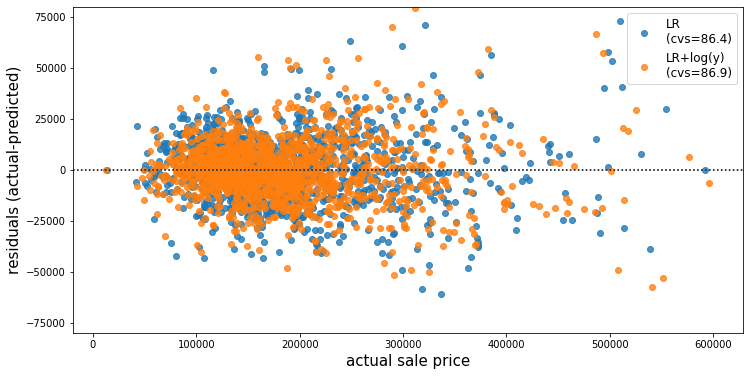

In [8]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_train, y_train, random_state=4)

ols = LinearRegression()
ols.fit(Xs_train, ys_train)
print('cvs:', cross_val_score(ols, Xs_test, ys_test, cv=5).mean())
ys_pred = ols.predict(Xs_train)

ys_train_log = ys_train.apply(np.log)
ys_test_log = ys_test.apply(np.log)

ols = LinearRegression()
ols.fit(Xs_train, ys_train_log)
print('logged cvs:', cross_val_score(ols, Xs_test, ys_test_log, cv=5).mean())
ys_pred_log = ols.predict(Xs_train)
ys_pred_log = np.exp(ys_pred_log)

plt.figure(figsize=(12,6))
sns.residplot(ys_pred, ys_train, label='LR\n(cvs=86.4)')
sns.residplot(ys_pred_log, ys_train, label='LR+log(y)\n(cvs=86.9)', )
plt.yticks(range(-125000, 125000, 25000))
plt.ylabel('residuals (actual-predicted)', fontsize=15)
plt.xlabel('actual sale price', fontsize=15)
plt.ylim(-80000, 80000)
plt.legend(fontsize=12);


Okay. Now let's try Ridge.

### Ridge

In [9]:
# scale
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [10]:
# Manual alpha
ridge = Ridge(alpha=3)
ridge.fit(Z_train, y_train)
print('a = 3 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 3 (manual)
cvs: 0.8896095232579807 (mean)
cvs: [0.89373093 0.9252105  0.88083363 0.90598888 0.84228367]


In [11]:
# Which alpha should we choose ?
ridge = Ridge(alpha=1200)
ridge.fit(Z_train, y_train)
print('a = 1200 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 1200 (manual)
cvs: 0.8897393856982834 (mean)
cvs: [0.90649162 0.92217386 0.85275145 0.91129032 0.85598969]


Looking better. But I used a random alpha. Maybe RidgeCV can find a better one.

In [33]:
sns.set()
sns.set_style("white")


<Figure size 432x288 with 0 Axes>

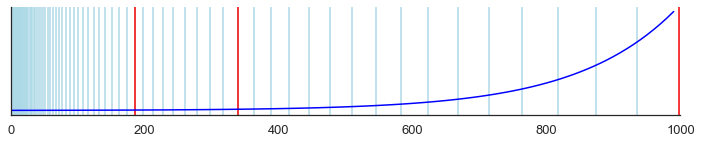

In [47]:
plt.figure(figsize=(12,2))
for vl in np.logspace(.1,3,100):
    plt.axvline(x=vl, color='lightblue')
plt.axvline(x=186, color='red')
plt.axvline(x=340, color='red')
plt.axvline(x=998, color='red')

sns.lineplot(range(0, 1000, 10), np.logspace(.1,3,100), color='blue')
plt.xlim([0,1000])
plt.xticks(fontsize=13)
plt.yticks([])
sns.despine()

In [ ]:
# Using Matt's example logspace
ridge_alphas = np.logspace(1,3,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
print(f'a = {ridge_cv.alpha_} (found)') 
cvs = cross_val_score(ridge_cv, Z_train, y_train, cv=5)
print('cvs:', cvs.mean(), '(mean)')
print('cvs:', cvs)

**How does my T/T split affect Ridge CV's alpha?**

In [13]:
for ttseed in [7, 17, 27, 37]:
    # t/t split
    Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=ttseed)
    # ridge
    ridge_cv = RidgeCV(alphas=np.logspace(1.5,2.5,100), scoring='r2', cv=5)
    ridge_cv.fit(Zs_train, ys_train)
    train_score = ridge_cv.score(Zs_train, ys_train)
    test_score = ridge_cv.score(Zs_test, ys_test)
    alpha = ridge_cv.alpha_
    print(f'TT seed: {ttseed} | train r2: {train_score} | test r2: {test_score} | alpha = {alpha}')

TT seed: 7 | train r2: 0.9417228693749599 | test r2: 0.9308757391702726 | alpha = 82.0618709130545


/Users/jfitz/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


TT seed: 17 | train r2: 0.9403975413981757 | test r2: 0.9046142618352306 | alpha = 316.22776601683796
TT seed: 27 | train r2: 0.9354603364214105 | test r2: 0.9008694395659804 | alpha = 316.22776601683796
TT seed: 37 | train r2: 0.9407544495897827 | test r2: 0.8913463834441979 | alpha = 316.22776601683796


In [16]:
def plot_ridge_alphas(rs_range, rs_count, a_range, a_step, y_lim=[.75, 1], np_seed=42, vlines=False, legend=True ):
    plt.figure(figsize=(16,8))
    np.random.seed(np_seed)
    for seed in np.random.randint(0, rs_range, rs_count):
        x = []
        y = []
        for a in range(1, a_range, a_step):   # int list
       # for a in np.logspace(.9, , 100):    # np.log
            x.append(a)
            Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=seed)
            ridge = Ridge(alpha=a)
            ridge.fit(Zs_train, ys_train)
            test_score = ridge.score(Zs_test, ys_test)
            y.append(test_score)
        plt.plot(x, y,
                 marker='.',
                 label=seed)
        if vlines==True:
            plt.axvline(x[y.index(max(y))])
    plt.ylim(y_lim)
    plt.ylabel('test R2 score', fontsize=14)
    plt.xlim(0, a_range)
    plt.xlabel('Ridge alpha', fontsize=14)
    if legend==True:
        plt.legend(loc='upper right', title='t-t r split seed', fontsize=12);

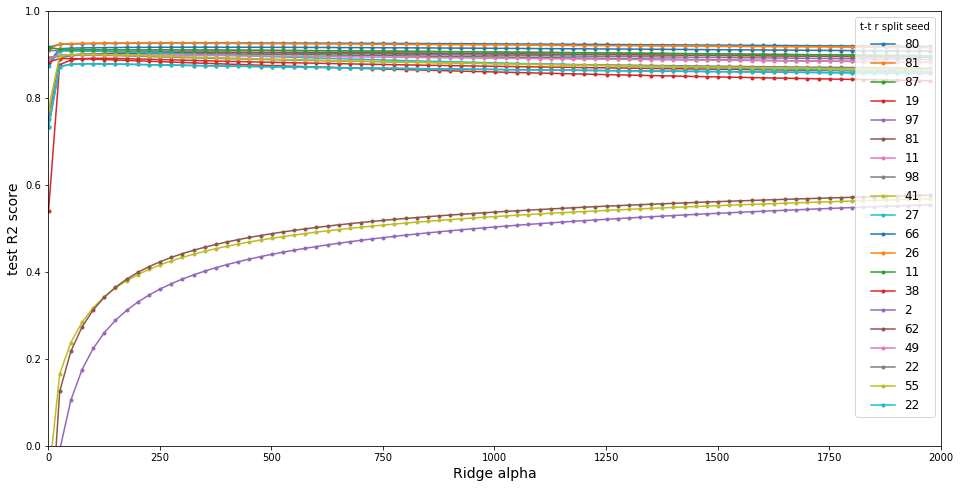

In [17]:
plot_ridge_alphas(100, 20, 2000, 25, y_lim=[0, 1], np_seed=117)

Let's run RidgeCV with every t/t seed between 0-100 to see where they congregate...

In [ ]:
# get alphas for ridgeCV in seed range 0-100
alphas = pd.read_csv('datasets/ttseed_alphas.csv')

In [ ]:
plt.figure(figsize=(16,1.5))
plt.xlim(0, 2000)
plt.hist(alphas['0'], bins=40, );
plt.xticks(range(0, 2100,100));
plt.xlabel('.alpha_', fontsize=14)
plt.ylabel('count', fontsize=14)

Zooming in 0 < α < 100

In [ ]:
plot_ridge_alphas(500, 50, 100, 2, y_lim=[.7, 1], legend=False)

Let's try to figure out what's going on in one of our stranger splits

In [ ]:
# rs = 55 is really strange
Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=11)
ridge_alphas = np.logspace(1,3,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Zs_train, ys_train)
ridge_cv.score(Zs_train, ys_train), ridge_cv.score(Zs_test, ys_test), ridge_cv.alpha_

In [ ]:
print('train:', ridge_cv.score(Zs_train, ys_train))
print('test:',  ridge_cv.score(Zs_test, ys_test))
print('alpha:', ridge_cv.alpha_)

In [ ]:
# split with rs55, manual alpha
ridge = Ridge(alpha=80)
ridge.fit(Zs_train, ys_train)
print('a = 80 (manual) | rs = 55')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5))

Finally, predict using RidgeCV searching within our optimal alpha range

In [ ]:
y_train_log = y_train.apply(np.log)

In [ ]:
ridge_alphas = np.logspace(1.5,1.9,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train_log)
ridge_cv.score(Z_train, y_train_log), ridge_cv.alpha_

In [ ]:
y_pred = ridge_cv.predict(Z_test)

In [ ]:
# create output df
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = np.exp(y_pred)

output.head()

In [ ]:
#output.to_csv('submissions/submission_34_log.csv', index=False)

---
## Lasso

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
# Set up a list of Lasso alphas to check.
lasso_alphas = np.logspace(-2.3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=50000)

In [ ]:
lasso_cv.fit(Z_train, y_train['SalePrice']);

In [ ]:
lasso_cv.alpha_

---
## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:

logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear")
logreg_cv.fit(Z_train, y_train['SalePrice'])
print(logreg_cv.score(Z_train, y_train['SalePrice']))